In [1]:
%matplotlib inline
import sys
sys.path.append("/home/diego/Dropbox/hold_noise/iclamp-glm/")

import matplotlib.pyplot as plt
import numpy as np

from icglm.models.glm import GLM
from icglm.kernels.rect import KernelRect
from icglm.processes import AutoCorr, OUProcess

from scipy.linalg import solveh_banded

%load_ext autoreload
%autoreload 2

Starting gradient ascent... 

 Iteration 16 of 20 | Elapsed time: 3.39 seconds | log_prior=-21.27 | log_posterior=-125.86
 
 Iteration 16 of 20 | Converged | Elapsed time: 0.0566 minutes | Log posterior is monotonic 



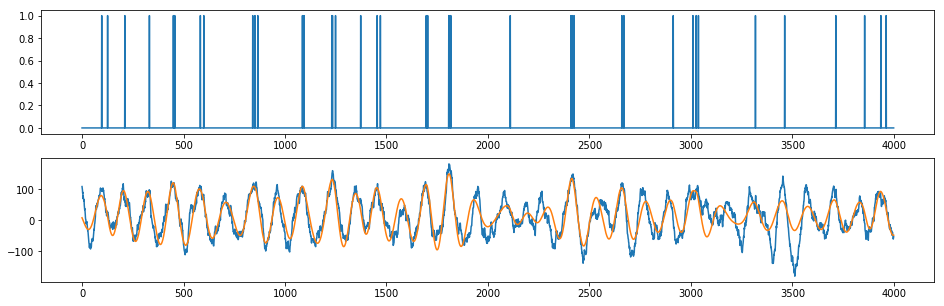

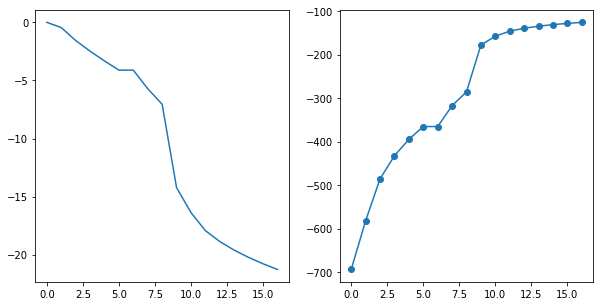

In [2]:
def autocorr(t, f, tau):
    return np.cos(2 * np.pi * f * t) * np.exp(-np.abs(t / tau))

t = np.arange(0, 4000, 1)
f, tau = 8 / 1000, 150
mu, sd = 10, 60
npp = AutoCorr(mu=mu, sd=sd, autocorr_fun=autocorr, pars=dict(f=f, tau=tau))
npp.set_prior_on_t(t, t_max_band_cov=tau * 10, eps_max_band_inv_cov=1e-6, inv_cov=True, cholesky=True)

stim_true = npp.sample(t, seed=1)
kappa = KernelRect.exponential(tf=240, dt=8, tau=40, A=1e-2)
eta = KernelRect.exponential(tf=450, dt=25, tau=75, A=7)
u0 = 16
glm_true = GLM(u0=u0, kappa=kappa, eta=eta)

np.random.seed(0)
v, r, mask_spk_true = glm_true.sample(t, stim_true)

fig, (ax1, ax2) = plt.subplots(figsize=(16, 5), nrows=2)
ax1.plot(t, mask_spk_true)
ax2.plot(t, stim_true)

newton_kwargs = dict(max_iterations=20, stop_cond=5e-4, learning_rate=5e-2, initial_learning_rate=5e-3, warm_up_iterations=5)

stim0 = np.zeros(len(t)) + mu
stim_dec, optimizer = glm_true.decode(t, mask_spk_true, stim0=stim0, prior=npp, newton_kwargs=newton_kwargs, verbose=True)
ax2.plot(t, stim_dec)

fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
ax1.plot(optimizer.log_prior_iterations)
ax2.plot(optimizer.log_posterior_iterations, '-o')

In [3]:
import seaborn as sns
from cycler import cycler

rc_poster={'figure.figsize': (3.5, 3.), 'axes.labelsize': 26, 'lines.linewidth': 2, 'lines.markersize': 10,
                           'xtick.labelsize': 24, 'ytick.labelsize': 24, 'errorbar.capsize': 5,
                           'legend.fontsize': 24, 'axes.spines.top': False, 'axes.spines.right': False,
                           'axes.prop_cycle': cycler(color=['dodgerblue', '#CD4545', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                                                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])}

rc_google={'figure.figsize': (10 / 2.54, 10 / 2.54), 'axes.labelsize': 18, 'lines.linewidth': 1, 'lines.markersize': 5,
                           'xtick.labelsize': 16, 'ytick.labelsize': 16, 'errorbar.capsize': 5,
                           'legend.fontsize': 16, 'axes.spines.top': False, 'axes.spines.right': False,
                           'axes.prop_cycle': cycler(color=['dodgerblue', '#CD4545', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                                                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])}

# sns.set(style="ticks", rc=rc_google)
sns.set(style="ticks", rc=rc_poster)

# order = ['3w', '4w', '5w', 'm']
# age_colors = ['#ffb777', '#ff7f0e', 'crimson', 'k']
# palette = dict(zip(order, age_colors))

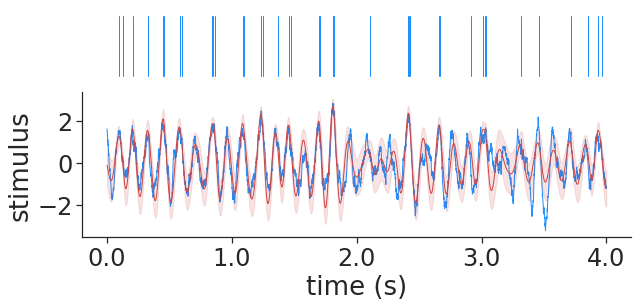

In [4]:
# fig, ax = plt.subplots(figsize=(16, 5))
# myplt.set_size_cm(fig, (25, 10.5))
# # axs[-1].set_xticks([3000, 3500, 4000])
# myplt.set_scale_axis(axs[-1], x_scale=1000, round_x=False)
# ax2[-1].set_xlabel('time (s)')
# ax2[-1].set_ylabel('stimulus');
# ax2[-1].set_yticks([-2, 0, 2])
# ax.plot(t, stim_true, color='dodgerblue')
# ax.plot(t, stim_dec, color='#CD4545')

import sys
sys.path.append("/home/diego/Dropbox/Python/imports/")
from scipy.linalg import cholesky_banded, solve_triangular
from icglm.utils.linalg import unband_matrix
from icglm.plot.decoding import DecodingPlotter
import myplt

h_log_posterior_banded = optimizer.h_log_posterior
inv_cov_banded_cholesky = cholesky_banded(-h_log_posterior_banded, lower=True)
inv_cholesky = unband_matrix(inv_cov_banded_cholesky, symmetric=False, lower=True)
cholesky = solve_triangular(inv_cholesky, np.eye(inv_cholesky.shape[1]), lower=True)
var_stim_dec = np.sum(cholesky ** 2, 0)

xi_dec = (stim_dec - np.mean(stim_dec)) / np.std(stim_dec)
xi_true = (stim_true - np.mean(stim_true)) / np.std(stim_true)
var_stim_dec = var_stim_dec / np.var(stim_dec)
plotter = DecodingPlotter(t=t, model='glm', optimizer=optimizer, mask_spikes=[mask_spk_true], stim_dec=xi_dec, stim_true=xi_true, 
                          var_stim_dec=var_stim_dec)
fig, axs = plotter.plot_decoded_stimulus(stim_kwargs=dict(lw=1))
myplt.set_size_cm(fig, (25, 10.5))
# axs[-1].set_xticks([3000, 3500, 4000])
myplt.set_scale_axis(axs[-1], x_scale=1000, round_x=False)
axs[-1].set_xlabel('time (s)')
axs[-1].set_ylabel('stimulus');
axs[-1].set_yticks([-2, 0, 2])
fig.savefig('/home/diego/Dropbox/hold_noise/figures/model_fitting/example_dec_oscillations.pdf', bbox_inches='tight')
fig.savefig('/home/diego/Dropbox/hold_noise/figures/model_fitting/example_dec_oscillations.svg', transparent=True, bbox_inches='tight')

In [5]:
def autocorr(t, tau):
    return np.exp(-np.abs(t / tau))

t = np.arange(0, 2000, 1)
tau = 10
mu, sd = 30, 30
ou = GeneralCov(mu=mu, sd=sd, autocorr_fun=autocorr, pars=dict(tau=tau))
ou.set_cov(t, t_max_band_cov=tau * 20)

stim = ou.sample(seed=1)
kappa = KernelRect.exponential(tf=240, dt=8, tau=40, A=1e-2)
eta = KernelRect.exponential(tf=450, dt=25, tau=75, A=7)
u0 = 16
glm_true = GLM(u0=u0, kappa=kappa, eta=eta)
np.random.seed(0)
r, kappa_conv, eta_conv, mask_spk_true = glm_true.simulate(t, stim)

r, kappa_conv, eta_conv, mask_spk_true = glm_true.simulate(t, stim)
fig, (ax1, ax2) = plt.subplots(figsize=(16, 5), nrows=2)
ax1.plot(t, mask_spk_true)
ax2.plot(t, stim)

newton_kwargs = dict(max_iterations=100, stop_cond=1e-6, learning_rate=1e-1, initial_learning_rate=1e-3, warm_up_iterations=5)

stim_true = stim.copy()

stim0 = np.zeros(len(t)) + mu
stim_dec, optimizer = glm_true.decode(t, mask_spk_true, stim0=stim0, mu_I=0, sd_I=1, Ih=mu, prior=ou, newton_kwargs=newton_kwargs, verbose=True)

npp2 = OUProcess(mu=mu, sd=sd, tau=tau)
stim_dec2, optimizer2 = glm_true.decode(t, mask_spk_true, stim0=stim0, mu_I=0, sd_I=1, Ih=mu, prior=npp2, newton_kwargs=newton_kwargs, verbose=True)
# fig, ax = plt.subplots(figsize=(16, 5))
ax2.plot(t, stim_dec)
ax2.plot(t, stim_dec2)
# ax2.plot(t, sd * np.cos(stim_dec) + mu)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(10, 5), nrows=2, ncols=2)
ax1.plot(optimizer.log_prior_iterations)
ax2.plot(optimizer.log_posterior_iterations, '-o')
ax3.plot(optimizer2.log_prior_iterations)
ax4.plot(optimizer2.log_posterior_iterations, '-o')

NameError: name 'GeneralCov' is not defined

In [41]:
1 / f

125.0